In [2]:
import librosa
import spleeter
import numpy as np
import soundfile as sf
import tensorflow as tf
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import librosa.display

In [226]:
!spleeter separate -o audio_output1 -p spleeter:4stems "kajra re 0.mpeg"

INFO:spleeter:File audio_output1\kajra re 0/other.wav written succesfully
INFO:spleeter:File audio_output1\kajra re 0/vocals.wav written succesfully
INFO:spleeter:File audio_output1\kajra re 0/drums.wav written succesfully
INFO:spleeter:File audio_output1\kajra re 0/bass.wav written succesfully


In [227]:
!spleeter separate -o audio_output1 -p spleeter:4stems "kajra re 1.mpeg"

INFO:spleeter:File audio_output1\kajra re 1/other.wav written succesfully
INFO:spleeter:File audio_output1\kajra re 1/bass.wav written succesfully
INFO:spleeter:File audio_output1\kajra re 1/drums.wav written succesfully
INFO:spleeter:File audio_output1\kajra re 1/vocals.wav written succesfully


In [256]:
def extract_features(y, sr):

    # Extract pitch (chroma) features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    # Extract rhythm (beat) features
    tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
    beat_features = np.sum(librosa.feature.chroma_cens(y=y, sr=sr, hop_length=512), axis=1)
    
    return chroma, beat_features

def evaluate_singing(features, reference_features):
    # Compute the cosine similarity between the features and the reference features
    similarity = np.dot(features, reference_features) / (np.linalg.norm(features) * np.linalg.norm(reference_features))
    
    return similarity

def score_singing(chroma_similarity, beat_similarity, weight=0.45):
    # Combine the scores by taking a weighted average
    score = weight * chroma_similarity + (1 - weight) * beat_similarity
    
    return score


def cosine_similarity(chroma1, chroma2):
    
    # Flatten the chroma arrays into 1-D arrays
    chroma1_flattened = chroma1.ravel()
    chroma2_flattened = chroma2.ravel()
    index=[]
    for i in range(len(chroma1_flattened)):
        if(chroma1_flattened[i]!=0 and chroma2_flattened[i]!=0):
            index.append(i)
            
    chroma1_flattened=np.array([chroma1_flattened[i] for i in index])
    chroma2_flattened=np.array([chroma2_flattened[i] for i in index])
    
    # Compute the dot product between the flattened arrays
    dot_product = np.dot(chroma1_flattened, chroma2_flattened)
    
    # Compute the magnitude of the flattened arrays
    magnitude1 = np.linalg.norm(chroma1_flattened)
    magnitude2 = np.linalg.norm(chroma2_flattened)
    
    # Compute the cosine similarity
    cosine_similarity = dot_product / (magnitude1 * magnitude2)
    
    return cosine_similarity


In [229]:
# Load the reference audio file
reference_path = r"C:\Users\prash\OneDrive\Desktop\music\audio_output1\kajra re 0\vocals.wav"
reference_y, reference_sr = librosa.load(reference_path)

In [230]:
reference_chroma, reference_beat_features = extract_features(reference_y, reference_sr)

In [231]:
# Load the audio file to be evaluated
audio_path = r"C:\Users\prash\OneDrive\Desktop\music\audio_output1\kajra re 1\vocals.wav"
audio_y, audio_sr = librosa.load(audio_path)

In [232]:
chroma, beat_features = extract_features(audio_y, audio_sr)

In [233]:
diff=abs(len(chroma[1])-len(reference_chroma[1]))

In [234]:
diff

2210

In [235]:
if(diff!=0):
    if(len(chroma[1])>len(reference_chroma[1])):
        chroma = chroma[:, :-diff]
    else:
        reference_chroma=reference_chroma[:,:-diff]

In [236]:
chroma.shape

(12, 8065)

In [237]:
reference_chroma.shape

(12, 8065)

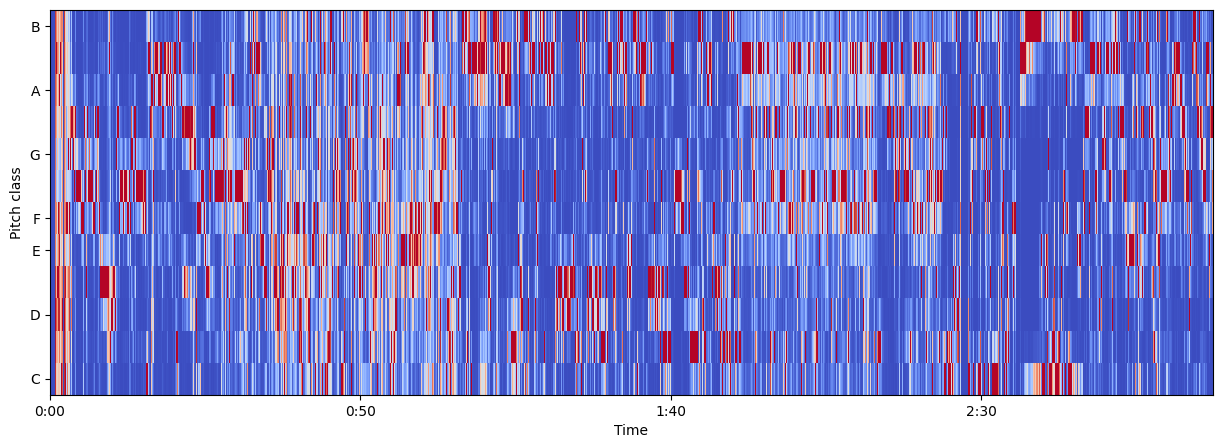

In [238]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.show()

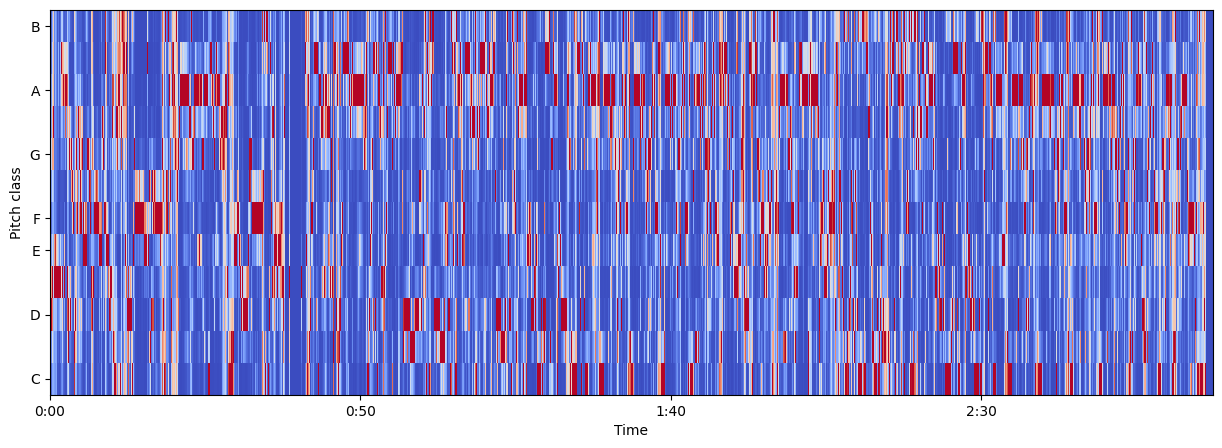

In [239]:
plt.figure(figsize=(15, 5))
librosa.display.specshow(reference_chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.show()

In [257]:
sim = cosine_similarity(chroma, reference_chroma)

In [258]:
beat_similarity = evaluate_singing(beat_features, reference_beat_features)

In [259]:
score=score_singing(sim,beat_similarity)*100

In [260]:
score

72.34926675242684

In [244]:
def rate_singing(y, sr):

    # Calculate the Mel-frequency cepstral coefficients (MFCCs)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

    # Calculate the prosody
    rms=librosa.feature.rms(y=y)[0]


    # Calculate the spectral flux
    spectrum = np.abs(librosa.stft(y))
    diff_spectrum = np.diff(spectrum)
    spectral_flux = np.sum(diff_spectrum, axis=1)

    # Calculate the pitch deviation
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitch_deviation = np.std(pitches)

    # Combine the scores into an overall score
    score = (np.mean(mfccs) +  np.mean(rms) + np.mean(spectral_flux) + pitch_deviation) / 4

    return score


In [261]:
score0=rate_singing(audio_y, audio_sr)

In [262]:
score0

60.764442443847656

In [263]:
score1=rate_singing(reference_y, reference_sr)

In [264]:
score1

80.23820495605469

In [265]:
score2=(score0/score1)*100

In [266]:
score2=(score0/score1)*100
if (score2>100):
    score2=(score1/score0)*100

In [267]:
score

72.34926675242684

In [268]:
score2

75.73006210336769

In [269]:
final=min(score2,score)

In [270]:
final

72.34926675242684

In [271]:
print(int(final))

72
